# 3. From a simple denoising model on MNIST to a basic Diffusion one

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 2.0 (17/01/2025)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.6.2)
- Numpy (tested on v2.2.1)
- Torch (tested on v1.12.1)

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
# Seeding for reproducibility
torch.manual_seed(18)
np.random.seed(47)

Diffusion models are computationally expensive, it is strongly advised that you have cuda enabled on your machine.

In [2]:
# CUDA check
device = "cuda" if (torch.cuda.is_available()) else "cpu"
print(torch.cuda.is_available())
print(device)

True
cuda


### MNIST Dataset

Let us start by preparing the datasets and dataloaders for MNIST. We have done this many times before.

In [3]:
# Prepare the MNIST dataset
# Hyperparameters
batch_size = 64
# Transformations
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0.5,), (0.5,))])
# Load MNIST dataset
train_dataset = MNIST(root="./data", train = True, \
                      transform = transform, download = True)
test_dataset = MNIST(root="./data", train = False, \
                     transform = transform, download = True)
# Data loaders
train_loader = DataLoader(train_dataset, \
                          batch_size = batch_size, \
                          shuffle = True)
test_loader = DataLoader(test_dataset, \
                         batch_size = batch_size, \
                         shuffle = False)
# Check data
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")

Batch shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])


### Noise scheduler

Will be used to add noise progressively, using a scheduler.

The cosine_beta_schedule function generates a sequence of beta values that determine how much noise is added at each step of the forward diffusion process. These beta values gradually increase over time, ensuring that the image becomes noisier as the steps progress.

The cosine schedule ensures that the noise is added smoothly and gradually. At the beginning of the process ($t=0$), most of the image is preserved, and very little noise is added. As the process progresses (t increases), more noise is added until the image becomes almost entirely random.

In [4]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = np.arange(timesteps + 1)
    alphas = np.cos(((steps / timesteps) + s) / (1 + s) * np.pi / 2) ** 2
    alphas = alphas / alphas[0]
    betas = 1 - (alphas[1:] / alphas[:-1])
    return torch.tensor(np.clip(betas, a_min=1e-5, a_max=0.02), dtype=torch.float32)

Each beta represents the amount of noise added to the image at a particular step. There is a progressive increase in the quantity of noise being added.

In [5]:
timesteps = 1000
betas = cosine_beta_schedule(timesteps).to("cpu")
print(betas[::10])

tensor([4.1284e-05, 8.9871e-05, 1.3850e-04, 1.8719e-04, 2.3598e-04, 2.8487e-04,
        3.3390e-04, 3.8310e-04, 4.3248e-04, 4.8207e-04, 5.3190e-04, 5.8199e-04,
        6.3237e-04, 6.8307e-04, 7.3412e-04, 7.8554e-04, 8.3736e-04, 8.8961e-04,
        9.4233e-04, 9.9555e-04, 1.0493e-03, 1.1036e-03, 1.1585e-03, 1.2141e-03,
        1.2703e-03, 1.3272e-03, 1.3849e-03, 1.4434e-03, 1.5028e-03, 1.5630e-03,
        1.6242e-03, 1.6864e-03, 1.7496e-03, 1.8140e-03, 1.8795e-03, 1.9463e-03,
        2.0144e-03, 2.0838e-03, 2.1547e-03, 2.2272e-03, 2.3013e-03, 2.3771e-03,
        2.4547e-03, 2.5343e-03, 2.6159e-03, 2.6997e-03, 2.7857e-03, 2.8742e-03,
        2.9652e-03, 3.0590e-03, 3.1557e-03, 3.2555e-03, 3.3586e-03, 3.4652e-03,
        3.5755e-03, 3.6899e-03, 3.8085e-03, 3.9318e-03, 4.0600e-03, 4.1935e-03,
        4.3327e-03, 4.4781e-03, 4.6301e-03, 4.7894e-03, 4.9564e-03, 5.1319e-03,
        5.3167e-03, 5.5115e-03, 5.7174e-03, 5.9354e-03, 6.1667e-03, 6.4127e-03,
        6.6749e-03, 6.9553e-03, 7.2559e-

The function below is used to progressively add noise over a given timestep. It consists of a single noise adding to an image $ x_{t-1} $ on timestep $ t $.
In the forward diffusion process, noise is gradually added in a recursive manner, over a series of timesteps.
At timestep $ t $, the noisy image $ x_t $ can be written as:

$$ x_t = \sqrt{\alpha_t x_{t-1}} + \sqrt{1 − \alpha_t} \epsilon $$

Where,
- $ \alpha_t $: A factor derived from the beta schedule, which decides how much noise is kept from the previous image and how much noise is added.
- $ \epsilon $: A Gaussian noise, with mean zero and variance one, to be added to the image.

Here, we have decided to define $ \alpha_t $ as a cumulative product of $ (1-\beta_i) $ up to timestep t, controlling how much of the original image remains. In other words, we have:

$$ \alpha_t = \prod_{i=0}^t (1 - \beta_i) $$

In [6]:
# Forward Diffusion Process
def forward_diffusion(x, t, betas):
    # Perform the forward diffusion process on original image x, timestep t and using the scheduler betas.
    # Returns a noisy image at timestep t, denoted x_t and the noise added to x.
    sqrt_alpha_cumprod = torch.sqrt((1 - betas).cumprod(dim=0))
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - (1 - betas).cumprod(dim=0))
    # Expand dimensions to match x
    sqrt_alpha_cumprod_t = sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
    # Gaussian noise
    noise = torch.randn_like(x)
    x_t = sqrt_alpha_cumprod_t * x + sqrt_one_minus_alpha_cumprod_t * noise
    return x_t, noise

Below we draw a single sample from the MNIST train dataloader. We then use the forward diffusion 1000 times in a row to show the progressive noising.

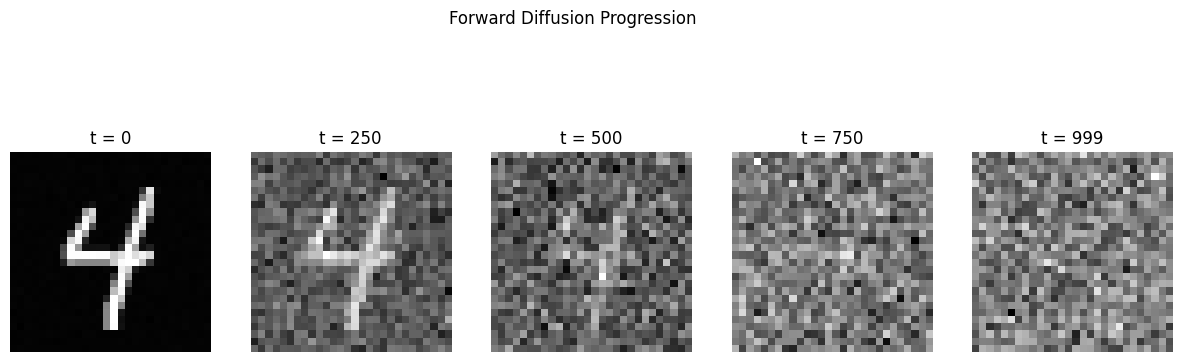

In [7]:
# Load MNIST dataset (just for one sample)
batch_size = 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = MNIST(root="./data", train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Sample a batch of MNIST images
data_iter = iter(data_loader)
x_0, _ = next(data_iter)

# Generate progressively noisier images over 1000 timesteps
timesteps = 1000
t_values = [0, timesteps // 4, timesteps // 2, 3 * timesteps // 4, timesteps - 1]
noisy_images = [forward_diffusion(x_0, torch.tensor([t]), betas)[0] for t in t_values]

# Plot the images
fig, axes = plt.subplots(1, len(t_values), figsize=(15, 5))
for i, t in enumerate(t_values):
    axes[i].imshow(noisy_images[i][0].squeeze(), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"t = {t}")

plt.suptitle("Forward Diffusion Progression")
plt.show()

### Model

Diffusion model to be used for denoising, will use a UNet (special kind of CNN architecture of with residuals).

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        # Skip connection to match dimensions if needed
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride) if in_channels != out_channels else nn.Identity()
    def forward(self, x):
        skip = self.skip(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return self.relu(x + skip)

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        # Encoder
        self.encoder1 = ResidualBlock(in_channels, 64)
        self.encoder2 = ResidualBlock(64, 128, stride=2)
        self.encoder3 = ResidualBlock(128, 256, stride=2)
        # Middle
        self.middle = nn.Sequential(
            ResidualBlock(256, 256),
            ResidualBlock(256, 256)
        )
        # Decoder
        self.decoder1 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                                      nn.ReLU(),
                                      ResidualBlock(128, 128))
        self.decoder2 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                                      nn.ReLU(),
                                      ResidualBlock(64, 64))
        self.decoder3 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)

        # Middle
        middle = self.middle(enc3)

        # Decoder with skip connections
        dec1 = self.decoder1(middle + enc3)  # Residual skip connection
        dec2 = self.decoder2(dec1 + enc2)    # Residual skip connection
        dec3 = self.decoder3(dec2 + enc1)    # Residual skip connection

        return torch.tanh(dec3)  # Output values in range [-1, 1]

In [10]:
# Initialize model
model = UNet().to(device)
print(model)

UNet(
  (encoder1): ResidualBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (skip): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (encoder2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  )
  (encoder3): ResidualBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (skip): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  )
  (middle): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (conv2): Con

### Progressive Denoising

Although the model has not been trained yet

In [11]:
# Generate a noisy image (start from the most noisy state, t = timesteps - 1)
x_0 = x_0.to(device)  # Ensure input data is on the same device
betas = betas.to(device)  # Ensure betas are on the same device
x_t = forward_diffusion(x_0, torch.tensor([timesteps - 1], device=device), betas)[0]

In [12]:
# Simulate the denoising process step-by-step
def reverse_diffusion_step(model, x_t, t, betas):
    sqrt_alpha_cumprod = torch.sqrt((1 - betas).cumprod(dim=0))
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - (1 - betas).cumprod(dim=0))
    coef1 = 1 / sqrt_alpha_cumprod[t].view(-1, 1, 1, 1).to(device)
    coef2 = sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1).to(device)
    noise_pred = model(x_t)
    x_t = coef1 * (x_t - coef2 * noise_pred)
    x_t = torch.clamp(x_t, -1.0, 1.0)  # Clamp values to valid range
    return x_t

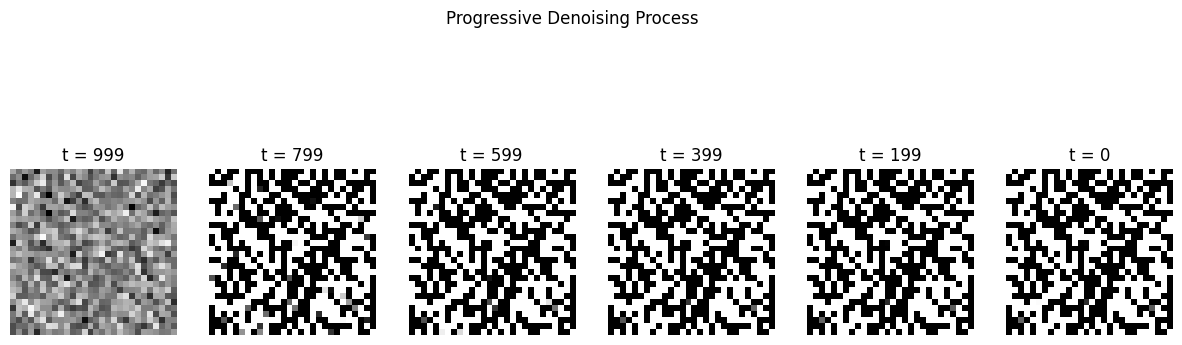

In [13]:
# Update t_values to include t = 0
t_values = list(range(timesteps - 1, -1, -timesteps // 5))  # Include 0 as the last step

# Perform progressive denoising
denoised_images = [x_t]

for t in t_values[:-1]:  # Skip t = 0 here since it's the last step
    x_t = reverse_diffusion_step(model, x_t, torch.tensor([t], device=device), betas)
    denoised_images.append(x_t)

# Add the final denoised result (t = 0)
x_t = reverse_diffusion_step(model, x_t, torch.tensor([0], device=device), betas)
denoised_images.append(x_t)

# Move denoised images back to CPU for visualization
denoised_images = [img.detach().cpu() for img in denoised_images]

# Plot the images
fig, axes = plt.subplots(1, len(denoised_images), figsize=(15, 5))
for i, img in enumerate(denoised_images):
    axes[i].imshow(img[0].squeeze(), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"t = {t_values[i]}" if i < len(t_values) else "t = 0")

plt.suptitle("Progressive Denoising Process")
plt.show()

### Training a denoising model

In [14]:
def train_denoising_model(model, train_loader, optimizer, criterion, betas, timesteps, device, epochs):
    # Preparing model, noise scheduler and losses values (for training curves later on)
    model.to(device)
    betas = betas.to(device)
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_idx, (x_0, _) in enumerate(train_loader):
            x_0 = x_0.to(device)
            # Sample random timesteps
            batch_size = x_0.size(0)
            t = torch.randint(0, timesteps, (batch_size,), device=device).long()
            # Forward diffusion
            x_t, noise = forward_diffusion(x_0, t, betas)
            # Predict the noise
            noise_pred = model(x_t)
            # Compute loss on noise using MSE
            loss = criterion(noise_pred, noise)
            # Backward pass and update loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # Average loss for the epoch
        avg_loss = epoch_loss/len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    return losses

In [15]:
# Hyperparameters
epochs = 50
learning_rate = 1e-4

# Model, optimizer, and loss function
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

Epoch [1/50], Loss: 0.2901
Epoch [2/50], Loss: 0.2158
Epoch [3/50], Loss: 0.2077
Epoch [4/50], Loss: 0.2026
Epoch [5/50], Loss: 0.1994
Epoch [6/50], Loss: 0.1966
Epoch [7/50], Loss: 0.1949
Epoch [8/50], Loss: 0.1931
Epoch [9/50], Loss: 0.1919
Epoch [10/50], Loss: 0.1907
Epoch [11/50], Loss: 0.1894
Epoch [12/50], Loss: 0.1892
Epoch [13/50], Loss: 0.1885
Epoch [14/50], Loss: 0.1878
Epoch [15/50], Loss: 0.1871
Epoch [16/50], Loss: 0.1869
Epoch [17/50], Loss: 0.1866
Epoch [18/50], Loss: 0.1860
Epoch [19/50], Loss: 0.1857
Epoch [20/50], Loss: 0.1855
Epoch [21/50], Loss: 0.1853
Epoch [22/50], Loss: 0.1851
Epoch [23/50], Loss: 0.1846
Epoch [24/50], Loss: 0.1843
Epoch [25/50], Loss: 0.1841
Epoch [26/50], Loss: 0.1842
Epoch [27/50], Loss: 0.1842
Epoch [28/50], Loss: 0.1839
Epoch [29/50], Loss: 0.1835
Epoch [30/50], Loss: 0.1838
Epoch [31/50], Loss: 0.1835
Epoch [32/50], Loss: 0.1835
Epoch [33/50], Loss: 0.1831
Epoch [34/50], Loss: 0.1828
Epoch [35/50], Loss: 0.1832
Epoch [36/50], Loss: 0.1827
E

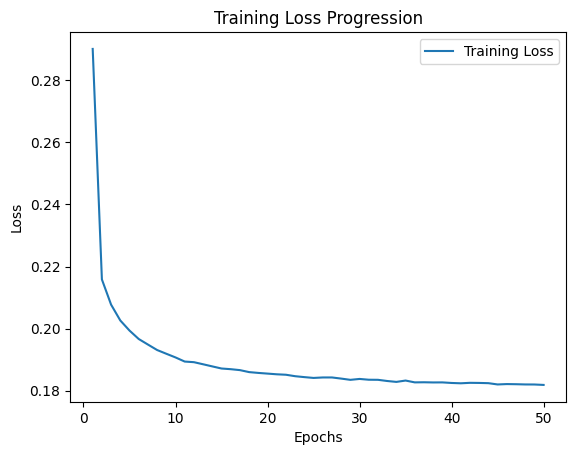

In [16]:
# Train the model
# (This might take a while!)
losses = train_denoising_model(model=model,
                               train_loader=train_loader,
                               optimizer=optimizer,
                               criterion=criterion,
                               betas=betas,
                               timesteps=timesteps,
                               device=device,
                               epochs=epochs)

# Plot training losses curves
plt.plot(range(1, epochs + 1), losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Progression")
plt.legend()
plt.show()

### Testing denoising model on noised MNIST images

In [17]:
# Function to perform reverse diffusion
def reverse_diffusion(model, x_t, timesteps, betas):
    sqrt_alpha_cumprod = torch.sqrt((1 - betas).cumprod(dim=0)).to(device)
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - (1 - betas).cumprod(dim=0)).to(device)
    for t in reversed(range(timesteps)):
        t_tensor = torch.tensor([t], device=device).long()
        noise_pred = model(x_t)
        coef1 = 1 / sqrt_alpha_cumprod[t_tensor].view(-1, 1, 1, 1)
        coef2 = sqrt_one_minus_alpha_cumprod[t_tensor].view(-1, 1, 1, 1)
        x_t = coef1 * (x_t - coef2 * noise_pred)
        # Clamp values to valid range
        x_t = torch.clamp(x_t, -1.0, 1.0)
    return x_t

In [18]:
# Visualize the reverse diffusion process
def visualize_results(model, dataset, timesteps, betas):
    model.eval()
    
    # Take a batch of data
    data_iter = iter(dataset)
    x_0, _ = next(data_iter)
    x_0 = x_0.to(device)
    
    # Add noise to the images
    t = torch.randint(0, timesteps, (x_0.shape[0],), device=device).long()
    x_t, _ = forward_diffusion(x_0, t, betas)
    
    # Reverse diffusion
    with torch.no_grad():
        x_0_hat = reverse_diffusion(model, x_t, timesteps, betas)
    
    # Visualize
    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    for i in range(10):
        axes[0, i].imshow(x_0[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(x_t[i].cpu().squeeze(), cmap="gray")
        axes[1, i].axis("off")
        axes[2, i].imshow(x_0_hat[i].cpu().squeeze(), cmap="gray")
        axes[2, i].axis("off")
    
    plt.suptitle("Top: Original | Middle: Noisy | Bottom: Reconstructed")
    plt.show()

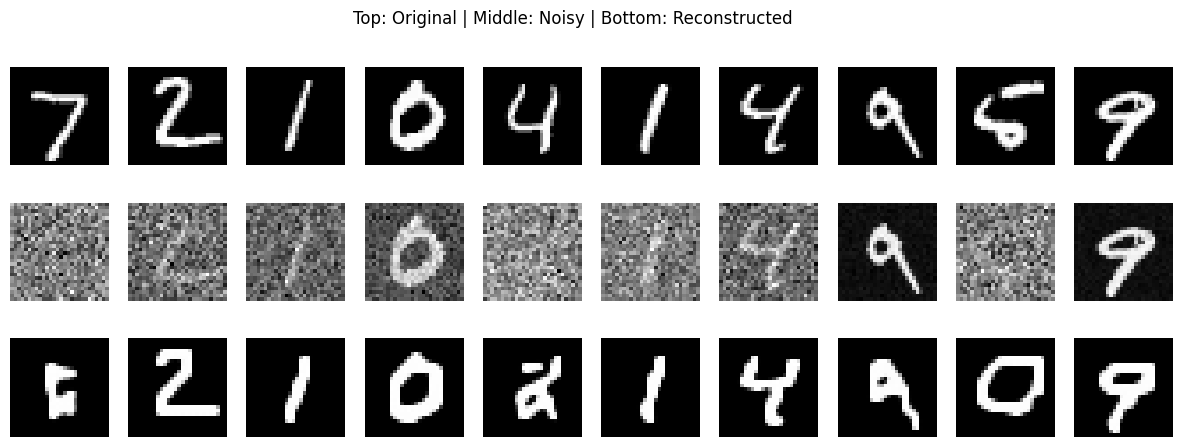

In [19]:
# Visualize results on test set
visualize_results(model, test_loader, timesteps, betas)

### Testing it on pure noise?

What would happen if we used a pure noise image?

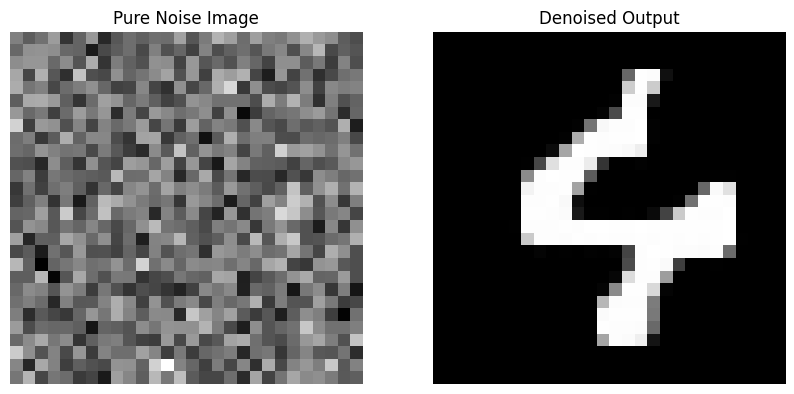

In [21]:
def generate_pure_noise(image_shape, device):
    return torch.randn(image_shape, device=device)

torch.manual_seed(6)
# Generate a pure noise image with the same shape as MNIST samples
pure_noise_image = generate_pure_noise((1, 1, 28, 28), device)

# Perform reverse diffusion on the pure noise image
denoised_image = reverse_diffusion(model, pure_noise_image, timesteps, betas)

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(pure_noise_image[0][0].cpu().detach(), cmap="gray")
axes[0].set_title("Pure Noise Image")
axes[0].axis("off")
axes[1].imshow(denoised_image[0][0].cpu().detach(), cmap="gray")
axes[1].set_title("Denoised Output")
axes[1].axis("off")
plt.show()